<a href="https://colab.research.google.com/github/gabemgem/Opinion-Misperception/blob/main/opinion_misperception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

# Opinion Misperception Game

In this game, we have a set of agents that have some opinion about the world. The opinion is either derived from a signal they receive from the world, or from the agent's partisan preferences. The agents are connected in a network and send messages about their opinion to their neighbors.

By changing agent distributions, network structure, and signal distribution, we observe the dynamics of opinion misperception in the network.

**Game Flow:**
1. Pick $g=\{0,1\}$ as the ground truth
2. Initialize $n$ agents
3. Assign types to agents
4. Assign signals to agents
5. Assign network connections
6. Send messages
7. Calculate perceptions and utilities

## Parameter Initialization

In [ ]:
n = 1000 # number of agents
m = 5 # number of initial neighbors (correlated to agent "attention")
alpha = 0.1 # preferential attachment
beta = 0.1 # importance of homophily relative to degree
gamma = 0.1 # how much minority partisan get higher attention/degree
type_distribution = [1, 1] # proportion of agents that are common, maj-partisan, or min-partisan
signal_truthiness = 1 # how much signal is correlated with truth
message_strategy = 1 # 0=always partisan, 1=truth with %, 2=heuristic message, 3=RL message

seed = 123
random.seed(seed)
# test addition

In [ ]:
class GameInstance_SingleRound_MotivatedPublicPerception():
    def __init__(self,
                 signal_agent_init_func=None, # Initialize groundtruth, agent types and incentives, and agent signals.
                 network_generation_func=None, # Create directed network of communication based on rules of homophilic-pref-attach.
                 communication_behavior_func=None, # Function to determine the communication behavior of each agent.
                 # Signal and Agent Type Parameters.
                 node_count_total=100, # Total number of individual agents communicating in the network.
                 type_distribution=[0.25, 0.25, 0.5], # Each on [0,1], and must sum to 1. See next line(s). Order corresponds to [false_partisan, true_partisan, truth_seeking].
                 false_partisan_percentage=type_distribution[0], # Fraction of total agents whom prefer public opinion to favor a particular outcome, which happens to be the fasleful outcome.
                 true_partisan_percentage=type_distribution[1],  # Fraction of total agents whom prefer public opinion to favor a particular outcome, which happens to be the truthful outcome.
                 truth_seeker_percentage=type_distribution[2],   # Fraction of total agents whom prefer public opinion to favor whichever outcome is truthful.
                 signal_truthiness_per_type=[0.75,0.75,0.75] # On [0.5,1] ?
                                                             # Proportion agents of the specified type that receive correct signals (equal to the ground truth).
                                                             # Should it be restricted to be >0.5 for all types? Is the truth-seeker signal truthiness interpretable as 'majority percentage'?
                                                             # Usually, makes sense to assume that all types of agents (partisan, not, etc.) recevie signals from the same distribution.
                                                             # This is perhaps realistic. But, perhaps it is more realistic for partisans to actually receive more truthful signals,
                                                             # since they may have more incentive and thus put in more effort into getting info from the world.
                                                             # And if partisan agent's communications are always partisan, then it may not even matter what signals partisan agents get...
                 # Network Generation Parameters

                 )

In [ ]:
class MisperceptionGame():
  def __init__(self, n, m, alpha=None, beta=None, gamma=None,
               type_distribution=None, signal_truthiness=None,
               message_strategy=None, random_seed=None):
    if random_seed is not None:
      random.seed(random_seed)
    self.n = n
    self.m = m
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
    self.type_distribution = type_distribution
    self.signal_truthiness = signal_truthiness
    self.message_strategy = message_strategy
    self.random_seed = random_seed

    self.G = None # nx.Graph
    self.messages = {}
    self.reset()

  def reset(self):
    pass

  def play(self):
    self.messages = send_messages(self.G, self.message_strategy)

  def visualize(self):
    pos = nx.spring_layout(self.G)
    colors = ['yellow' if self.G.nodes[node]['type'] == 'common' else 'green' if self.G.nodes[node]['type'] == 'maj-partisan' else 'red' for node in self.G.nodes()]
    nx.draw(self.G, pos, node_color=colors)
    plt.show()

  def get_stats(self):
    perceptions = [sum(self.messages[node])/len(self.messages[node]) for node in self.G.nodes()]
    global_perception = sum(perceptions)/len(perceptions)
    return perceptions, global_perception


In [ ]:
class MisperceptionModel1(MisperceptionGame):
  def __init__(self, n, m, type_distribution, random_seed=None):
    self.percent_minority = 1-type_distribution[0]
    super().__init__(n, m, type_distribution=type_distribution, message_strategy=0, random_seed=random_seed)


  def reset(self) -> None:
    self.G = nx.barabasi_albert_graph(self.n, self.m, seed=self.random_seed)
    for node in self.G.nodes():
      self.G.nodes[node]['signal'] = 1

    degrees = sorted(self.G.degree(), key=lambda x: x[1], reverse=True)
    num_minority = int(self.n * self.percent_minority)
    for i, (node, _) in enumerate(degrees):
      if i < num_minority:
        self.G.nodes[node]['type'] = 'min-partisan'
      else:
        self.G.nodes[node]['type'] = 'common'

class MisperceptionModel2(MisperceptionGame):
  def __init__(self, n, m, type_distribution, random_seed=None):
    super().__init__(n, m, type_distribution=type_distribution, message_strategy=0, random_seed=random_seed)

  def reset(self) -> None:
    self.G = nx.barabasi_albert_graph(self.n, self.m, seed=self.random_seed)
    for node in self.G.nodes():
      self.G.nodes[node]['signal'] = 1

    self.G = assign_agent_types(self.G, self.type_distribution)


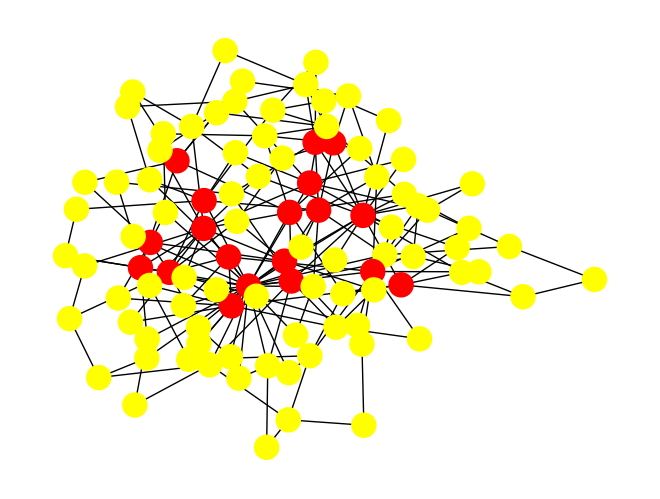

0.5013127705627706


In [ ]:
game = MisperceptionModel1(n=100, m=2, type_distribution=[0.80,0.80], random_seed=123)
game.play()
game.visualize()
print(game.get_stats()[1])


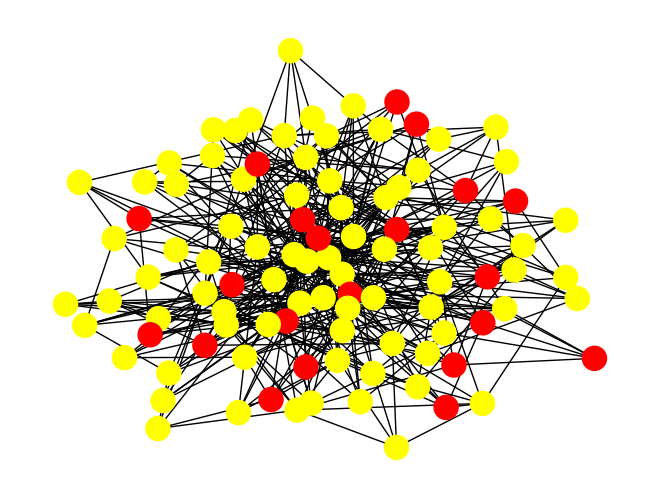

0.8043752008812645


In [ ]:
game = MisperceptionModel2(n=100, m=5, type_distribution=[0.7,0.70], random_seed=123)
game.play()
game.visualize()
print(game.get_stats()[1])

## Network Initialization

In [ ]:
def homophily(source_type, target_type, homophily_table):
    return homophily_table[source_type][target_type]

def preferential_attachment_pmf(G, n, new_node, existing_node, pref_attachment_vector):
    pref_attachment_vector = np.array(
      [
        homophily(
          G.nodes[new_node]['type'], G.nodes[existing_node]['type'], homophily_table
          ) *
      G.degree[existing_node] for existing_node in range(n)])

    pref_attachment_vector /= np.sum(pref_attachment_vector)
    return pref_attachment_vector




In [ ]:
def initialize_network(n: int) -> nx.Graph:
    G = nx.Graph()
    G.add_nodes_from(range(n))
    return G

In [ ]:
def assign_agent_types(G: nx.Graph, type_distribution: list) -> nx.Graph:
    for node in G.nodes:
        draw = random.random()
        if draw < type_distribution[0]:
            G.nodes[node]['type'] = 'common'
        elif draw < type_distribution[1]:
            G.nodes[node]['type'] = 'maj-partisan'
        else:
            G.nodes[node]['type'] = 'min-partisan'

    return G

In [ ]:
def assign_signals(G: nx.Graph, signal_truthiness: float) -> nx.Graph:
    for node in G.nodes:
        continue

    return G

In [ ]:
def assign_connections(G: nx.Graph, m: int, alpha: float, beta: float, gamma: float) -> nx.Graph:
    for node in G.nodes:
        continue

    return G

In [ ]:
G = initialize_network(n)
G = assign_agent_types(G, type_distribution)
G = assign_signals(G, signal_truthiness)
G = assign_connections(G, m, alpha, beta, gamma)

## Send Messages

In [ ]:
def send_messages(G: nx.Graph, message_strategy: int) -> dict:
  messages = { node: [] for node in G.nodes }
  for node in G.nodes:
      message = get_message(G, node, message_strategy)
      for neighbor in G.neighbors(node):
          messages[neighbor].append(message)

  return messages

def get_message(G: nx.Graph, node: int, message_strategy: int) -> int:
    if message_strategy == 0:
        return G.nodes[node]['signal'] if G.nodes[node]['type'] == 'common' else 1 if G.nodes[node]['type'] == 'maj-partisan' else 0
    elif message_strategy == 1:
        raise NotImplementedError("Message strategy not implemented yet")
    elif message_strategy == 2:
        raise NotImplementedError("Message strategy not implemented yet")
    elif message_strategy == 3:
        raise NotImplementedError("Message strategy not implemented yet")
    else:
        raise ValueError("Invalid message strategy")

In [ ]:
def play_game(G: nx.Graph, message_strategy: int) -> nx.Graph:
    G = send_messages(G, message_strategy)
    return G

In [ ]:
G = play_game(G, message_strategy)

## Calculate Perceptions and Utilities

In [ ]:
def average_neighbor_op(G, node):
    """
    Calculate the average 'op' value of all nodes connected to the given node.

    Parameters:
    G (networkx.Graph): The network
    node: The node to analyze

    Returns:
    float: Average 'op' value of neighboring nodes
    """
    neighbors = list(G.neighbors(node))
    if not neighbors:
        return None  # Return None if the node has no neighbors
    neighbor_ops = [G.nodes[neighbor]['op'] for neighbor in neighbors]
    return sum(neighbor_ops) / len(neighbor_ops)

def global_average_neighbor_op(G):
    """
    Calculate the average of average neighbor 'op' values for all nodes in the graph.

    Parameters:
    G (networkx.Graph): The network

    Returns:
    float: Global average of average neighbor 'op' values
    """
    avg_neighbor_ops = [average_neighbor_op(G, node) for node in G.nodes() if average_neighbor_op(G, node) is not None]
    return sum(avg_neighbor_ops) / len(avg_neighbor_ops)

def print_stats(G, print_all=True):
    """
    Print various statistics about the network
    Args:
        G (networkx.Graph): The network

    Returns:
        Nothing
    """
    if print_all:
        # Print network statistics
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Average clustering coefficient: {nx.average_clustering(G):.4f}")
        print(f"Average shortest path length: {nx.average_shortest_path_length(G):.4f}")

    # Count nodes with op=1 and op=0
    op_1_count = sum(1 for _, data in G.nodes(data=True) if data['op'] == 1)
    op_0_count = G.number_of_nodes() - op_1_count
    print(f"Nodes with op=1: {op_1_count} ({op_1_count/G.number_of_nodes()*100:.2f}%)")
    print(f"Nodes with op=0: {op_0_count} ({op_0_count/G.number_of_nodes()*100:.2f}%)")

    # Analyze relationship between degree and op value
    degrees = dict(G.degree())
    op_values = nx.get_node_attributes(G, 'op')
    degree_op_1 = [degree for node, degree in degrees.items() if op_values[node] == 1]
    degree_op_0 = [degree for node, degree in degrees.items() if op_values[node] == 0]

    print(f"\nAverage degree of nodes with op=1: {np.mean(degree_op_1):.2f}")
    print(f"Average degree of nodes with op=0: {np.mean(degree_op_0):.2f}")

    # Demonstrate the use of average_neighbor_op function
    # print("\nDemonstrating average_neighbor_op function:")
    # for i in range(5):  # Show results for first 5 nodes
    #     avg_op = average_neighbor_op(G, i)
    #     print(f"Node {i}: op = {G.nodes[i]['op']}, average neighbor op = {avg_op:.2f}")

    # Calculate and print global average of neighbor op values using the new function
    global_avg = global_average_neighbor_op(G)
    print(f"\nGlobal average of average neighbor op values: {global_avg:.4f}")

    # Analyze correlation between a node's op and its average neighbor op
    node_ops = [G.nodes[node]['op'] for node in G.nodes()]
    avg_neighbor_ops = [average_neighbor_op(G, node) for node in G.nodes()]
    correlation = np.corrcoef(node_ops, avg_neighbor_ops)[0, 1]
    print(f"Correlation between node op and average neighbor op: {correlation:.4f}")

## Visualization

In [ ]:
def draw_network(G: nx.Graph) -> None:
    pos = nx.spring_layout(G)
    colors = ['red' if G.nodes[node]['op'] == 1 else 'blue' for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=colors)
    plt.show()

In [ ]:
def plot_opinions():
    pass